In [2]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.animation as animation
from scipy.stats import multivariate_normal

In [3]:
def poly(x):
    return (-0.001 * x**6 + 0.003 * x**5 + 0.062 * x**4 - 
            0.174 * x**3 - 0.673 * x**2 + 1.323 * x + 1.764)

def trig_3d(X):
    x,y = X[:, 0], X[:, 1]
    
    return np.sin(0.5 * x) * np.cos(0.5 * y) + 0.3 * np.sin(1.0 * x) * np.cos(1.0 * y)

def gaussian_sine(x):
  """
  A 1D function with multiple distinct extrema of varying heights.
  """
  gaussian1 = 2 * np.exp(-((x + 3)**2) / 2)
  gaussian2 = 3 * np.exp(-((x - 1)**2) / 1)
  gaussian3 = 1.5 * np.exp(-((x - 4)**2) / 1.5)
  sin_wave = 0.3 * np.sin(2 * x)
  return gaussian1 + gaussian2 + gaussian3 + sin_wave

def plot_2d_acq_func(train_x, train_y, acq_f_name, model, black_box_func=None, bounds=(-5,5), iter_n=0):
    '''
    Input:
    train_x = tensor of train x data in 2D array format.
    train_y = tensor of train y data in 2D array format.
    acq_func = A string belonging to the following set {'LogEI', 'UCB', 'LogPI'}.
    model = Trained gaussian process regressor from the BOTorch library.
    bounds = Tuple consisting of upper and lower bounds for plotting and optimizing.
    black_box_func = Optional true black_box function for plotting purposes.

    output:
    2 plots:
    1st one shows the regressor, black box function (optional), 
    recommended candidate point from bayesian optimization and previously taken sample points
    against their respective y-values.
    2nd one is a plot of the given acquisition function.
    '''
    plt.rcParams['text.usetex'] = True

    title = 'Surrogate'
    plot_x = np.linspace(bounds[0],bounds[1],1000)
    plot_x_tensor = torch.tensor(plot_x.reshape(-1,1))

    acq_dict={
        'LogEI': [LogExpectedImprovement, train_y.max()],
        'UCB': [UpperConfidenceBound, 0.1],
        'LogPI': [ProbabilityOfImprovement, train_y.max()],
    }

    acq_func = acq_dict[acq_f_name][0](model, acq_dict[acq_f_name][1])
    
    bounds = torch.stack([bounds[0] * torch.ones(1), bounds[1] * torch.ones(1)]).to(torch.double)
    candidate, acq_value = optimize_acqf(acq_func, bounds=bounds, 
                                         q=1, num_restarts=5, raw_samples=20,)

    plot_acq_func = acq_func(plot_x_tensor.unsqueeze(-2)).detach().numpy()

    with torch.no_grad():
        model_mean = model.posterior(plot_x_tensor).mean

    fig, axs = plt.subplots(2)
    if black_box_func != None:
        plot_y = black_box_func(plot_x)
        axs[0].plot(plot_x_tensor.numpy(), plot_y, 
                    label="Black box function", color="red")
        title += ', Black Box function'
    title += r' vs. respective $y$-values'

    axs[0].plot(plot_x_tensor.numpy(), model_mean.numpy(), 
                label="GP Mean", color="blue", linestyle='dashed')
    
    if iter_n >0:
        axs[0].scatter(train_x[:-1],train_y[:-1], color = 'orange', label="Sample points")
        axs[0].scatter(train_x[-1],train_y[-1], color='red', label='Sample point from last iteration', edgecolors='black', s=100)
    else:
        axs[0].scatter(train_x,train_y, color = 'orange', label="Sample points")        
    axs[0].scatter(candidate, black_box_func(candidate), label="candidate point", 
                   color = 'green')

    axs[1].plot(plot_x_tensor.numpy(), plot_acq_func, label=acq_f_name, color="orange", lw=2)
    axs[1].scatter(candidate, acq_value, 
                   color = 'green')
    
    fig.subplots_adjust(hspace=0.5)
    fig.legend(loc='center',bbox_to_anchor=(1.05, 0.5))
    axs[0].set_title(title)
    fig.suptitle(f'Bayesian Optimization at iteration {iter_n}')
    axs[1].set_title(f'Acquisition function {acq_f_name} evaluated at '+r'$x$')

    axs[0].set_ylabel('Yield')
    axs[1].set_ylabel(f'{acq_f_name}'+r'$(x)$')
    axs[0].set_xlabel(r'variable $x$')
    axs[1].set_xlabel(r'variable $x$')

    plt.show()
    return candidate, fig

def plot_heatmap_acq_func(train_x, train_y, acq_f_name, model, black_box_func=None, bounds=(-5,5), iter_n=0):
    '''
    Input:
    train_x = tensor of train x data in 2D array format.
    train_y = tensor of train y data in 2D array format.
    acq_func = A string belonging to the following set {'LogEI', 'UCB', 'LogPI'}.
    model = Trained gaussian process regressor from the BOTorch library.
    bounds = Tuple consisting of upper and lower bounds for plotting and optimizing.
    black_box_func = Optional true black_box function for plotting purposes.

    output:
    3 plots:
    1st one shows the heatmap of the true black box function given x_1 and x_2. (Optional)
    2nd one shows the heatmap of the model regressor given x_1 and x_2.
    3rd shows the heatmap of the chosen acquisition function given x_1 and x_2.
    '''
    plt.rcParams['text.usetex'] = True
    
    plot_x = np.linspace(bounds[0], bounds[1], 50)
    plot_y = np.linspace(bounds[0], bounds[1], 50)
    X, Y = np.meshgrid(plot_x, plot_y)
    plot_x_tensor = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)
    
    acq_dict = {
        'LogEI': [LogExpectedImprovement, train_y.max()],
        'UCB': [UpperConfidenceBound, 0.1],
        'LogPI': [ProbabilityOfImprovement, train_y.max()],
    }
    
    acq_func = acq_dict[acq_f_name][0](model, acq_dict[acq_f_name][1])
    bounds_tensor = torch.stack([bounds[0] * torch.ones(2), bounds[1] * torch.ones(2)]).to(torch.double)
    candidate, acq_value = optimize_acqf(acq_func, bounds=bounds_tensor, q=1, num_restarts=5, raw_samples=20)
    
    plot_acq_func = acq_func(plot_x_tensor.unsqueeze(-2)).detach().numpy()
    plot_acq_func = plot_acq_func.reshape(X.shape)
    
    with torch.no_grad():
        model_mean = model.posterior(plot_x_tensor).mean.numpy().reshape(X.shape)
    
    fig, axs = plt.subplots(3, 1, figsize=(8,8))

    if black_box_func:
        plot_z = black_box_func(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
        im1 = axs[0].imshow(plot_z, extent=[bounds[0], bounds[1], bounds[0], bounds[1]], origin='lower')
        cbar1 = fig.colorbar(im1, ax=axs[0])
        cbar1.set_label('Yield')
        axs[0].set_title('Black box function heatmap')
    
    im2 = axs[1].imshow(model_mean, extent=[bounds[0], bounds[1], bounds[0], bounds[1]], origin='lower')
    cbar2 = fig.colorbar(im2, ax=axs[1])
    cbar2.set_label('Yield')
    axs[1].set_title('Surrogate function heatmap')
    
    im3 = axs[2].imshow(plot_acq_func, extent=[bounds[0], bounds[1], bounds[0], bounds[1]], origin='lower')
    cbar3 = fig.colorbar(im3, ax=axs[2])
    cbar3.set_label(acq_f_name+r'$(x_1,x_2)$')
    axs[2].set_title(f'Acquisition function {acq_f_name} heatmap')
    
    for ax in axs:
        ax.scatter(train_x[:, 0], train_x[:, 1], color='orange')
        if iter_n >0:
            ax.scatter(train_x[:-1, 0], train_x[:-1, 1], color='orange', label='Sample points', alpha=0.7)
            ax.scatter(train_x[-1, 0], train_x[-1, 1], color='red', label='Sample point from last iteration', edgecolors='black', s=100)
        else:
            ax.scatter(train_x[:, 0], train_x[:, 1], color='orange', label='Sample points', alpha=0.7)
        ax.scatter(candidate[0, 0], candidate[0, 1], color='green', label='Candidate')  
        ax.set_xlabel(r'variable $x_1$')
        ax.set_ylabel(r'variable $x_2$')
    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center', bbox_to_anchor=(1.05, 0.5))
    
    fig.suptitle(f'Bayesian Optimization at iteration {iter_n}', horizontalalignment='left')
    fig.subplots_adjust(hspace=0.4)
    plt.show()
    return candidate, fig


In [ ]:
def plot_3d_acq_func(train_x, train_y, acq_f_name, model, black_box_func=None, bounds=(-5,5), iter_n=0, frames=None):
    '''
    Similar to plot_2d_acq_func, but extends the visualization to 3D.
    '''
    plt.rcParams['text.usetex'] = True
    
    plot_x = np.linspace(bounds[0], bounds[1], 50)
    plot_y = np.linspace(bounds[0], bounds[1], 50)
    X, Y = np.meshgrid(plot_x, plot_y)
    plot_x_tensor = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)
    
    acq_dict = {
        'LogEI': [LogExpectedImprovement, train_y.max()],
        'UCB': [UpperConfidenceBound, 0.1],
        'LogPI': [ProbabilityOfImprovement, train_y.max()],
    }
    
    acq_func = acq_dict[acq_f_name][0](model, acq_dict[acq_f_name][1])
    bounds_tensor = torch.stack([bounds[0] * torch.ones(2), bounds[1] * torch.ones(2)]).to(torch.double)
    candidate, acq_value = optimize_acqf(acq_func, bounds=bounds_tensor, q=1, num_restarts=5, raw_samples=20)
    
    plot_acq_func = acq_func(plot_x_tensor.unsqueeze(-2)).detach().numpy()
    plot_acq_func = plot_acq_func.reshape(X.shape)
    
    with torch.no_grad():
        model_mean = model.posterior(plot_x_tensor).mean.numpy().reshape(X.shape)
    
    fig = plt.figure(figsize=(8,8))
    
    ax1 = fig.add_subplot(311, projection='3d')
    ax2 = fig.add_subplot(312, projection='3d')
    ax3 = fig.add_subplot(313, projection='3d')
    
    axs = [ax1, ax2]

    if black_box_func:
        plot_z = black_box_func(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
        ax1.plot_surface(X, Y, plot_z, color='purple', alpha=0.5, label='Black box function')
    
    ax2.plot_surface(X, Y, model_mean, color='blue', alpha=0.5, label='GP Mean')
    
    for ax in axs:
        if iter_n > 0:
            ax.scatter(train_x[:-1, 0], train_x[:-1, 1], train_y[:-1], color='orange', label='Sample points')
            ax.scatter(train_x[-1, 0], train_x[-1, 1], train_y[-1], color='red', label='Last iteration')
        else:
            ax.scatter(train_x[:, 0], train_x[:, 1], train_y, color='orange', label='Sample points')
    
        ax1.scatter(candidate[0, 0], candidate[0, 1], black_box_func(candidate), color='green', label='Candidate')
    
    ax3.plot_surface(X, Y, plot_acq_func, color='orange', alpha=0.5, label=acq_f_name)
    ax3.scatter(candidate[0, 0], candidate[0, 1], acq_value, color='green')

    ax1.set_title(r'Black box function vs. respective $y$-values')
    ax2.set_title(r'Surrogate function vs. respective $y$-values')
    ax3.set_title(f'Acquisition function {acq_f_name} evaluated at '+r'$x$')
    
    fig.suptitle(f'Bayesian Optimization at iteration {iter_n}')
    fig.subplots_adjust(hspace=0.25) 
    plt.show()

    if frames:
        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame)
        return candidate, frames
    else:
        return candidate


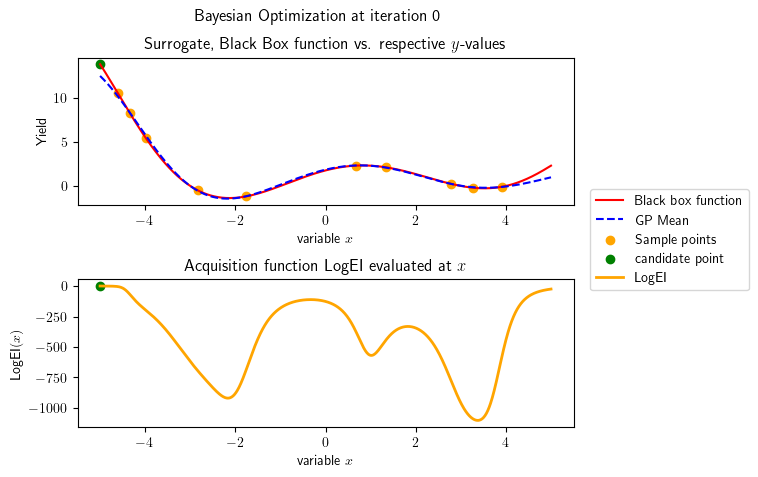

In [3]:
train_x_np = np.random.uniform(low=-5, high=5, size=10)
train_y_np = poly(train_x_np)

train_x = torch.tensor(train_x_np.reshape(-1,1))
train_y = torch.tensor(train_y_np.reshape(-1,1))

gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)
    
candidate, _ = plot_2d_acq_func(train_x, train_y, 'LogEI', gp, poly)

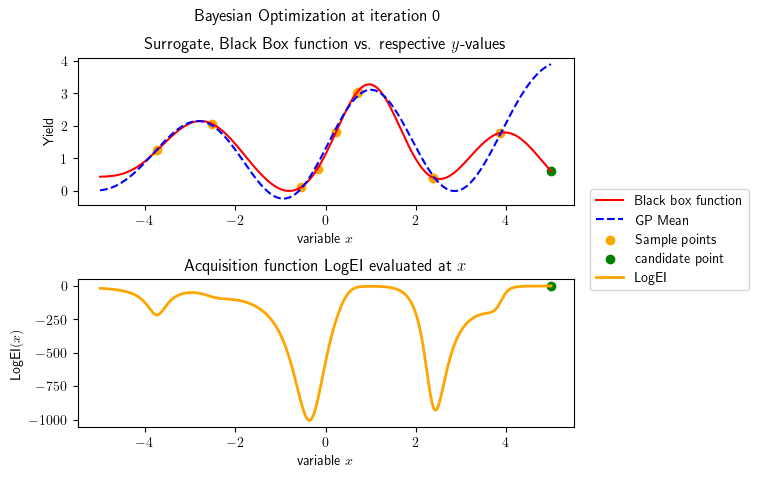

In [4]:
train_x_np = np.random.uniform(low=-5, high=5, size=10)
train_y_np = gaussian_sine(train_x_np)

train_x = torch.tensor(train_x_np.reshape(-1,1))
train_y = torch.tensor(train_y_np.reshape(-1,1))

gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)
    
candidate, _ = plot_2d_acq_func(train_x, train_y, 'LogEI', gp, gaussian_sine)

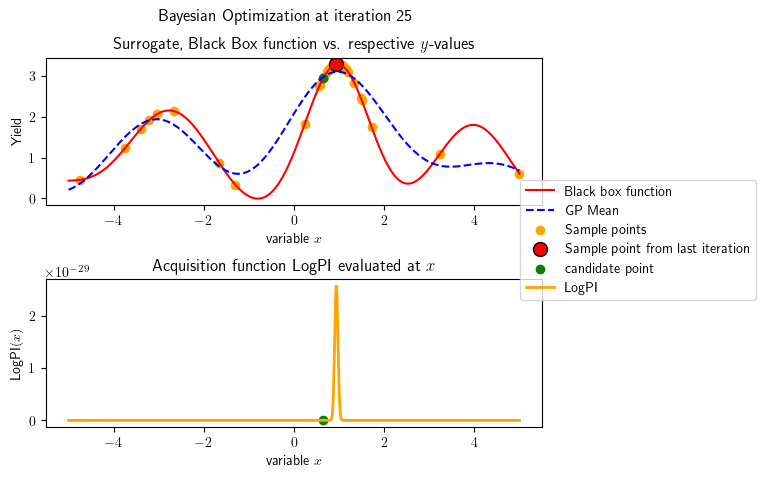

In [7]:
train_x_np = np.random.uniform(low=-5, high=5, size=10)
train_y_np = gaussian_sine(train_x_np)
previous_candidate = 1e-5
count = 0

frames = []

for i in range(50):
    clear_output(wait=True)  

    train_x = torch.tensor(train_x_np.reshape(-1,1))
    train_y = torch.tensor(train_y_np.reshape(-1,1))

    gp = SingleTaskGP(
        train_X=train_x,
        train_Y=train_y,
        input_transform=Normalize(d=1),
        outcome_transform=Standardize(m=1),
    )
    
    candidate, fig = plot_2d_acq_func(train_x, train_y, 'LogPI', gp, gaussian_sine, iter_n=i)

    train_x_np = np.append(train_x_np, float(candidate[0, 0]))
    train_y_np = np.append(train_y_np, gaussian_sine(float(candidate[0, 0])))

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(frame)

    if candidate.numpy()[0,0] - previous_candidate <= 1e-3:
        count += 1
        if count > 2:
            break
    else: 
        count = 0
    previous_candidate = candidate.numpy()[0,0]

def update(frame):
    fig.clf()
    fig.figimage(frames[frame])

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=500)
ani.save("bayesian_optimization_2d_logpi.gif", writer="pillow")
plt.close()
    

    

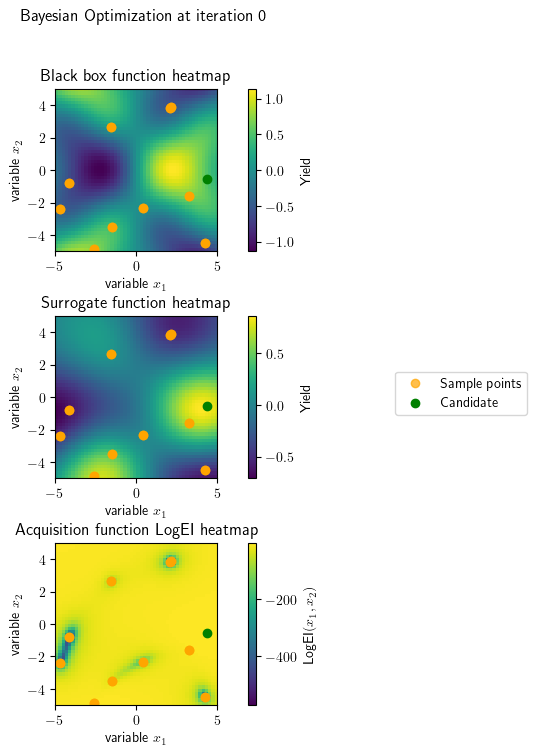

In [8]:
train_x_np = np.random.uniform(low=-5, high=5, size=(10, 2))
train_y_np = trig_3d(train_x_np)

train_x = torch.tensor(train_x_np, dtype=torch.double)
train_y = torch.tensor(train_y_np.reshape(-1, 1), dtype=torch.double)

gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=2),
    outcome_transform=Standardize(m=1),
)

candidate, _= plot_heatmap_acq_func(train_x, train_y, 'LogEI', gp, trig_3d)

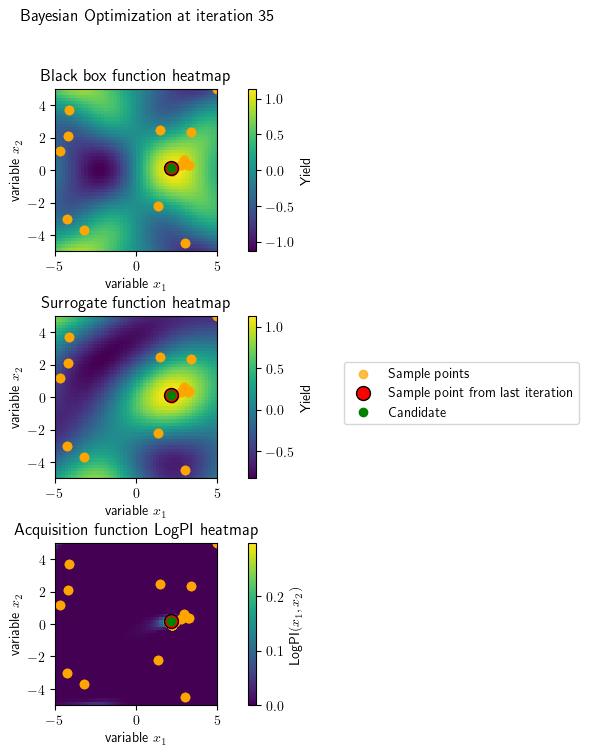

In [11]:
train_x_np = np.random.uniform(low=-5, high=5, size=(10, 2))
train_y_np = trig_3d(train_x_np)
previous_candidate = np.array([1e-5, 1e-5])
count = 0

frames = []

for iter_n in range(50):
    clear_output(wait=True)
      
    train_x = torch.tensor(train_x_np, dtype=torch.double)
    train_y = torch.tensor(train_y_np.reshape(-1, 1), dtype=torch.double)

    gp = SingleTaskGP(
        train_X=train_x,
        train_Y=train_y,
        input_transform=Normalize(d=2),
        outcome_transform=Standardize(m=1),
    )
    
    candidate, fig = plot_heatmap_acq_func(train_x, train_y, 'LogPI', gp, trig_3d, iter_n=iter_n)
    candidate_np= candidate.numpy().reshape(1, 2)
    
    train_x_np = np.vstack([train_x_np, candidate_np])
    train_y_np = np.append(train_y_np, trig_3d(candidate_np))

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(frame)

    if np.linalg.norm(candidate_np - previous_candidate) <= 1e-3:
        count += 1
        if count > 2:
            break
    else:
        count = 0
    
    previous_candidate = candidate_np

def update(frame):
    fig.clf()
    fig.figimage(frames[frame])

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=500)
ani.save("bayesian_optimization_heatmap_logpi.gif", writer="pillow")
plt.close()
    